**NOTE:** We are using the Julia 1.9.2 Kernel for this workbook.

In [1]:
using HDF5
using JSON
using Plots

using GraphicalModelLearning #GML
# GML from Los Alamos National Laboratory
# https://github.com/lanl-ansi/GraphicalModelLearning.jl

# Benchmark Workflow

The *benchmark performer* shall:
1. Select an `instance.<uuid-x>.json` file from the `benchmark_instances` directory.
2. Generate samples from the instance using their method and hardware of choice.  The `instance.<uuid-x>.json` file includes the appropriate time limit and number of samples $k$ to generate.
3. Write the samples they generated to `solution.<uuid-y>.hdf5` file in the `benchmark_performer_submissions` folder.  Metadata fields inside of the `solution.<uuid-y>.hdf5` reference the original `instance.<uuid-x>.json` file and UUID.


The *benchmark proctor* shall:
1. Select a `solution.<uuid-y>.hdf5` file and perform verification that the $k$ samples were accurately drawn from the system of interest.
2. Write out performance metrics to a `performance_metrics.<uuid-z>.json` file in the `benchmark_proctor_performance_metrics` directory.


Optionally:  a script will parse `performance_metrics.*.json` files in the `benchmark_proctor_performance_metrics` directory and present summary statistics, plots, etc.




In [2]:
# Acting as the Benchmark Proctor
#
# Fetch the solution.<uuid-y>.h5 file the benchmark performer submitted


# fixed filename/UUID for this example:
filename = "../benchmark_performer_submissions/solution.ee69de1e-3620-11ee-be05-8f4ea6fc831a.EXAMPLE.h5"
instance_uuid = HDF5.h5read(filename, "solution/instance_uuid") # original test instance
solution_uuid = HDF5.h5read(filename, "solution/solution_uuid") # solution submitted by performer
println("Benchmark Performer Submitted Solution UUID:",solution_uuid)

solution = HDF5.h5read(filename, "solution");
counts = solution["solution_reported"]["states_observed_counts"];
states = solution["solution_reported"]["states_observed"]

# first column is number of observations (counts).  
# we organize the samples in this way for compatibility with the GraphicalModelLearning package.
samples = hcat(counts, transpose(states));


Benchmark Performer Submitted Solution UUID:ee69de1e-3620-11ee-be05-8f4ea6fc831a


In [3]:
# Acting as the Benchmark Proctor
#
# Read in the adjacency matrix and external field from the ORIGINAL instance.<uuid-x>.json field


# fixed filename/UUID for this example:
filename = "../benchmark_instances/instance." * instance_uuid * ".EXAMPLE.json"
instance_data = JSON.parsefile(filename)


metadata = instance_data["metadata"]
graph_data = instance_data["graph_data"]

k_B = metadata["k_B"]
temperature_T = metadata["temperature_T"]






n = length(graph_data["nodes"])

# reassemble interaction_strength_J matrix from dictionary:
interaction_strength_J = zeros(n,n)
for edge in graph_data["links"]
    i = edge["source"] + 1 # plus 1 because we are going from base0 to base1
    j = edge["target"] + 1
    w = edge["weight"]
    interaction_strength_J[i,j] = w
    interaction_strength_J[j,i] = w
end

external_field_B = zeros(n)
for node in graph_data["nodes"]
    i = node["id"] + 1 # plus 1 because we are going from base0 to base1
    external_field_B[i] = node["B"]
end



# manually factor in the Boltzmann constant and temperature_T
beta = (1/(k_B*temperature_T))

interaction_strength_J *= beta;
external_field_B *= beta;

In [4]:
# Acting as the Benchmark Proctor
#
# Use the GraphicalModelLearning package to estimate 
# the original graph parameters and topology using 
# only the samples submitted by the benchmark performer.


# The output is in the form of an adjacency matrix for the original graph.
# The diagonal of the matrix is the external field strength.

GML_method = GraphicalModelLearning.logRISE()
learned_adj_matrix = GraphicalModelLearning.learn(samples, GML_method)

learned_external_field_B = [learned_adj_matrix[i,i] for i in 1:n];



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



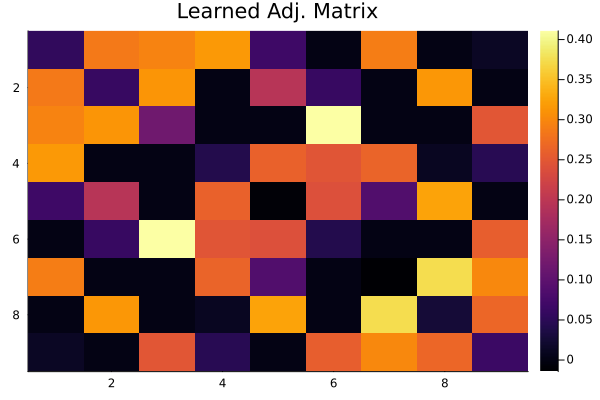

In [5]:
heatmap(learned_adj_matrix, yflip=true)
title!("Learned Adj. Matrix")

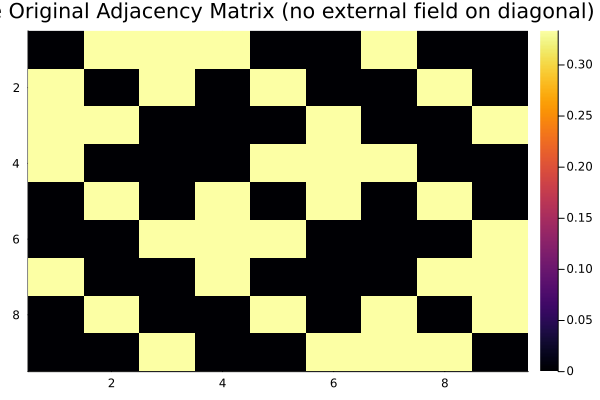

In [6]:
heatmap(interaction_strength_J, yflip=true)
title!("The Original Adjacency Matrix (no external field on diagonal)")


length of parameters:45


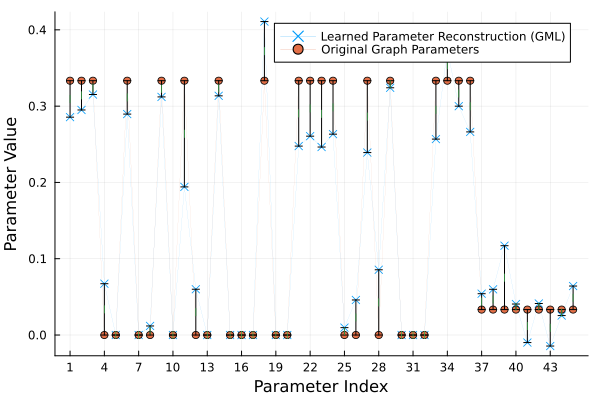

In [7]:
# vectorize all parameters J_ij, B_i to calculate differences

learned_param_vector = []
original_param_vector = []
for i in 1:n
    for j in i+1:n 
        push!(learned_param_vector, learned_adj_matrix[i,j])
        push!(original_param_vector, interaction_strength_J[i,j])
    end
end

# a single vector includes all J_ij and B_i terms.
for i in 1:n
    push!(learned_param_vector, learned_external_field_B[i])
    push!(original_param_vector, external_field_B[i])
end

println("length of parameters:", length(learned_param_vector))

plot(xticks=1:3:length(learned_param_vector))
plot!(xlabel="Parameter Index")
plot!(ylabel="Parameter Value")
plot!(learned_param_vector, line=false, marker=:x, label="Learned Parameter Reconstruction (GML)")
plot!(original_param_vector, line=false, marker=:circle, label="Original Graph Parameters")


# hacky way to show vertical error bars between `learned` and `original` on the plot.
x = 0.5*(learned_param_vector - original_param_vector);
scatter!(1:length(learned_param_vector), learned_param_vector - x, label=missing, line=true, marker=:vline, yerr=x)



We have use the `GraphicalModelLearning.jl` package to estimate the parameters of the system from the set of samples that the benchmark performer returned. Call these estimates $\hat{\theta}$. We know the true original $\theta$ parameters of the model from reading the benchmark instance file.  So now we will calculate various norms of the difference $x = \hat{\theta} - \theta$.

* $\ell_0$ ``norm'': sum of the nonzero elements of $x$
* $\ell_1$ norm: sum of the absolute value of all elements of $x$
* $\ell_2$ norm: $\sqrt{\sum_i x^2_i}$.  I.e., the Euclidean norm.
* $\ell_\infty$ norm: the maximum absolute value of all elements of $x$:  $\text{max}_i \{ | x_i | \}$ 

In all norms, a value close to zero indicates that the model that was reconstructed from the samples closely resembles the true system model.

In [8]:
x = learned_param_vector - original_param_vector
println("number of parameters:",length(learned_param_vector))


tolerance = 1e-9
ell_0_norm = sum( abs.(x) .>= tolerance*ones(length(learned_param_vector)))
println("ell_0 norm (small is good): $ell_0_norm")

ell_1_norm = sum( abs.(x) )
println("ell_1 norm (small is good): $ell_1_norm")

ell_2_norm = sqrt( sum( x.^2 ) )
println("ell_2 norm (small is good): $ell_2_norm")

ell_inf_norm = maximum( abs.(x) )
println("ell_inf norm (small is good): $ell_inf_norm")




number of parameters:45
ell_0 norm (small is good): 45


ell_1 norm (small is good): 1.5984457392103342
ell_2 norm (small is good): 0.3325495222560268


ell_inf norm (small is good): 0.13916517004812767


When the number of nodes $n$ in the system is small enough, we also calculate the KL-Divergence metric and the Total Varation Distance.  We need $n$ to be small enough because we will be explicitly calculating the true probability distribution function (PDF) over all $2^n$ possible system states.

In the following cells, we calculate the `true_pdf` $Q(s)$  from the original system parameters and the `empirical_pdf` $P(s)$ from the counts of samples/states returned by the benchmark performer.

\begin{equation}
\text{KL-divergence} = \sum_{s \in \{-1,+1\}^n} P(s) \log  \left( \frac{P(s)}{Q(s)} \right)
\end{equation}

\begin{equation}
\text{Total Variation Distance} = \sup_{s \in \{-1,+1\}^n} | P(s) - Q(s) |
\end{equation}


For both metrics, smaller is better and zero indicates that the distributions are identical.

See also

https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence

https://en.wikipedia.org/wiki/Total_variation_distance_of_probability_measures


In [9]:
# some utility functions to switch between spin_config vector and state_index

function convert_state_index_to_spin_config(state_index, n)
    spin_config = zeros(n)
    uint_1 = UInt128(1) #TODO: ensure proper bit width wrt n
    for i in 0:n-1
        bit = (state_index & (uint_1<<i) != 0)
        spin_config[i+1] = 2.0*bit - 1.0
    end
    return spin_config
end;

function convert_spin_config_to_state_index(spin_config)
    state_index = UInt128(0) #TODO: ensure proper bit width wrt n
    uint_1 = UInt128(1)
    n = length(spin_config)
    for i in 1:n
        if spin_config[i] > 0
            state_index = state_index | (uint_1<<(i-1))
        end
    end

    # state_index will be zero for all spin down (-1)
    # state_index will be Int(2^n-1) for all spin up (+1)
    return state_index
end;



In [10]:
@assert n <= 20

J = interaction_strength_J
for i in 1:n
    for j in 1:i
        J[i,j] = 0 # set this to an upper triangular matrix with zero diagonal.
    end
end


true_pdf = zeros(2^n)
for state_index in 0:2^n-1
    spin_config = convert_state_index_to_spin_config(state_index, n)
    energy = transpose(spin_config)*J*spin_config + transpose(external_field_B)*spin_config
    true_pdf[state_index + 1] = exp(energy) # note that -beta is already factored into J,B
end
Z = sum(true_pdf);
true_pdf *= (1/Z);

println("done")


done


In [11]:
@assert n <= 20

empirical_pdf = zeros(2^n)
num_unique_states_observed = size(samples)[1]
for sample_row in 1:num_unique_states_observed
    count = samples[sample_row,1]
    spin_config = samples[sample_row,2:end]
    # println(count , spin_config)
    state_index = convert_spin_config_to_state_index(spin_config)
    empirical_pdf[state_index + 1] = count
end
empirical_pdf *= 1.0/sum(empirical_pdf)


println("done")


done


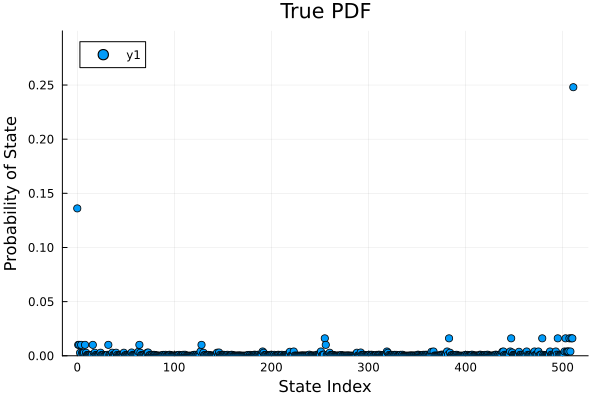

In [12]:
@assert n <= 20

plot(scatter(0:2^n-1,true_pdf, ylim=[0,0.3]))
title!("True PDF")
xlabel!("State Index")
ylabel!("Probability of State")

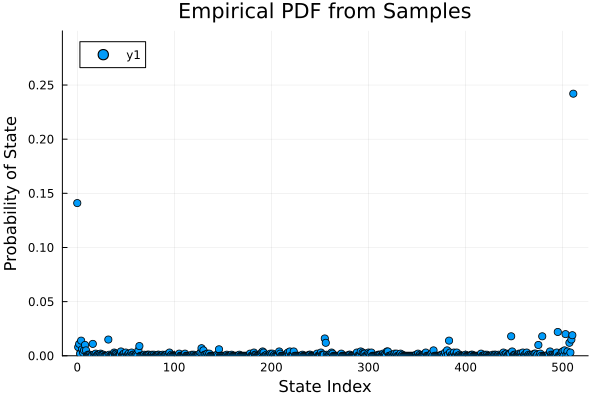

In [13]:
@assert n <= 20

plot(scatter(0:2^n-1, empirical_pdf, ylim=[0,0.3]))
title!("Empirical PDF from Samples")
xlabel!("State Index")
ylabel!("Probability of State")

In [14]:
@assert n <= 20

kl_divergence = 0.0
for state_index = 0:2^n-1
    p = empirical_pdf[state_index + 1]
    if p < 1e-9 # p is zero or very close 
        # the contribution to kl_divergence is zero because lim_{x->0} xlogx = 0.
        # TODO: figure out a way to vectorize this math instead of a loop
        # but you have to fix up the log(0)=-Inf issue.
        continue 
    end
    
    q = true_pdf[state_index + 1]
    kl_divergence += p*log(p/q)
end
println("kl_divergence (small is good):",kl_divergence)

kl_divergence (small is good):0.2209876339741972


In [15]:
@assert n <= 20

total_variation_distance = maximum( abs.(empirical_pdf - true_pdf))
println("total_variation_distance (small is good):",total_variation_distance)

total_variation_distance (small is good):0.006025002966386563


Finally the performance metrics are written out to a JSON file `performance_metrics.<uuid-z>.json` in the `benchmark_proctor_performance_metrics` folder.  

We skip that part of the example here because we have a Julia script that performs all calculations *in addition to* checking for the latest version of the calculation script.  See `/scripts/benchmark_proctor_evaluation.jl`.